> Note: If you came here trying to figure out how to create simulated X-ray photons and observations,
  you should go [here](http://hea-www.cfa.harvard.edu/~jzuhone/pyxsim/) instead.

This functionality provides the ability to create metallicity-dependent X-ray luminosity, emissivity, and photon emissivity fields for a given photon energy range.  This works by interpolating from emission tables created from the photoionization code [Cloudy](https://www.nublado.org/) or the collisional ionization database [AtomDB](http://www.atomdb.org). These can be downloaded from https://yt-project.org/data from the command line like so:

`# Put the data in a directory you specify`  
`yt download cloudy_emissivity_v2.h5 /path/to/data`

`# Put the data in the location set by "supp_data_dir"`  
`yt download apec_emissivity_v3.h5 supp_data_dir`

The data path can be a directory on disk, or it can be "supp_data_dir", which will download the data to the directory specified by the `"supp_data_dir"` yt configuration entry. It is easiest to put these files in the directory from which you will be running yt or `"supp_data_dir"`, but see the note below about putting them in alternate locations.

Emission fields can be made for any energy interval between 0.1 keV and 100 keV, and will always be created for luminosity $(\rm{erg~s^{-1}})$, emissivity $\rm{(erg~s^{-1}~cm^{-3})}$, and photon emissivity $\rm{(photons~s^{-1}~cm^{-3})}$.  The only required arguments are the
dataset object, and the minimum and maximum energies of the energy band. However, typically one needs to decide what will be used for the metallicity. This can either be a floating-point value representing a spatially constant metallicity, or a prescription for a metallicity field, e.g. `("gas", "metallicity")`. For this first example, where the dataset has no metallicity field, we'll just assume $Z = 0.3~Z_\odot$ everywhere:

In [1]:
import yt

ds = yt.load(
    "GasSloshing/sloshing_nomag2_hdf5_plt_cnt_0150", default_species_fields="ionized"
)

xray_fields = yt.add_xray_emissivity_field(
    ds, 0.5, 7.0, table_type="apec", metallicity=0.3
)

> Note: If you place the HDF5 emissivity tables in a location other than the current working directory or the location 
  specified by the "supp_data_dir" configuration value, you will need to specify it in the call to 
  `add_xray_emissivity_field`:  
  `xray_fields = yt.add_xray_emissivity_field(ds, 0.5, 7.0, data_dir="/path/to/data", table_type='apec', metallicity=0.3)`

Having made the fields, one can see which fields were made:

In [2]:
print(xray_fields)

[('gas', 'xray_emissivity_0.5_7.0_keV'), ('gas', 'xray_luminosity_0.5_7.0_keV'), ('gas', 'xray_photon_emissivity_0.5_7.0_keV')]


The luminosity field is useful for summing up in regions like this:

In [3]:
sp = ds.sphere("c", (2.0, "Mpc"))
print(sp.quantities.total_quantity(("gas", "xray_luminosity_0.5_7.0_keV")))

7.519078276881073e+44 erg/s


Whereas the emissivity fields may be useful in derived fields or for plotting:


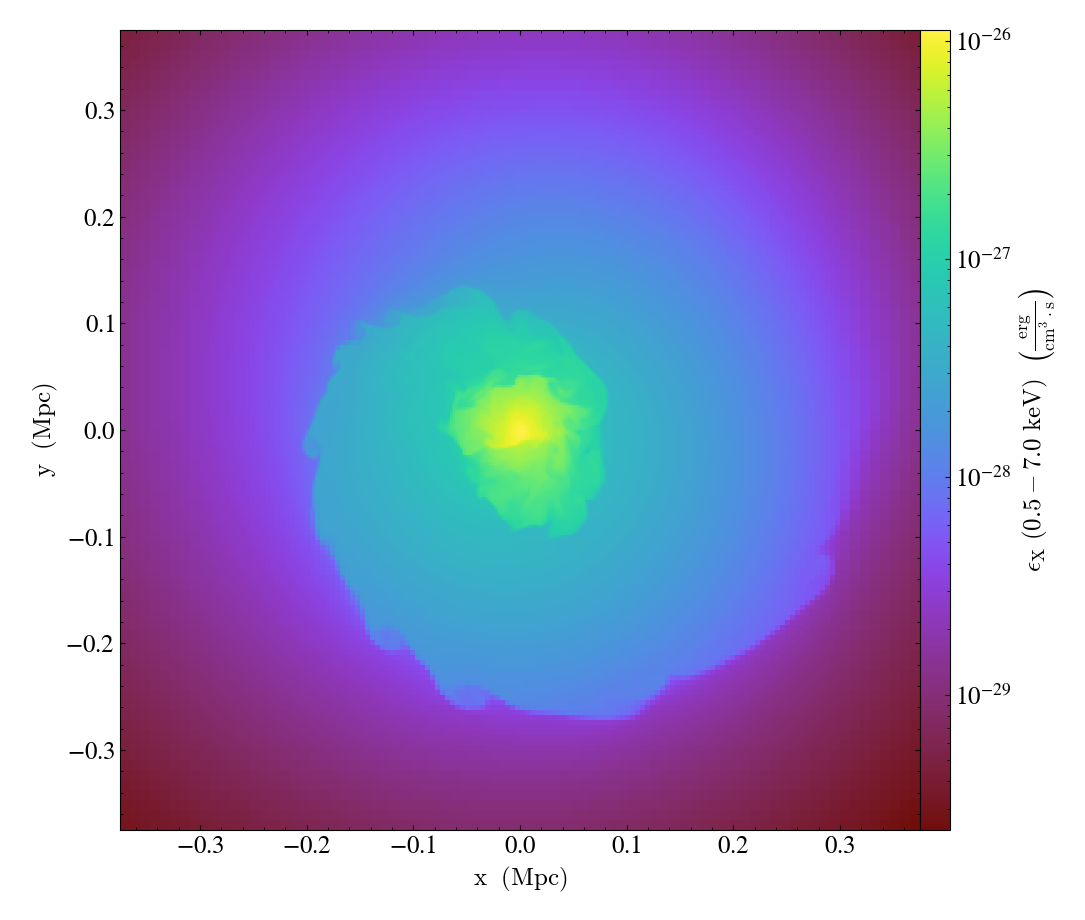
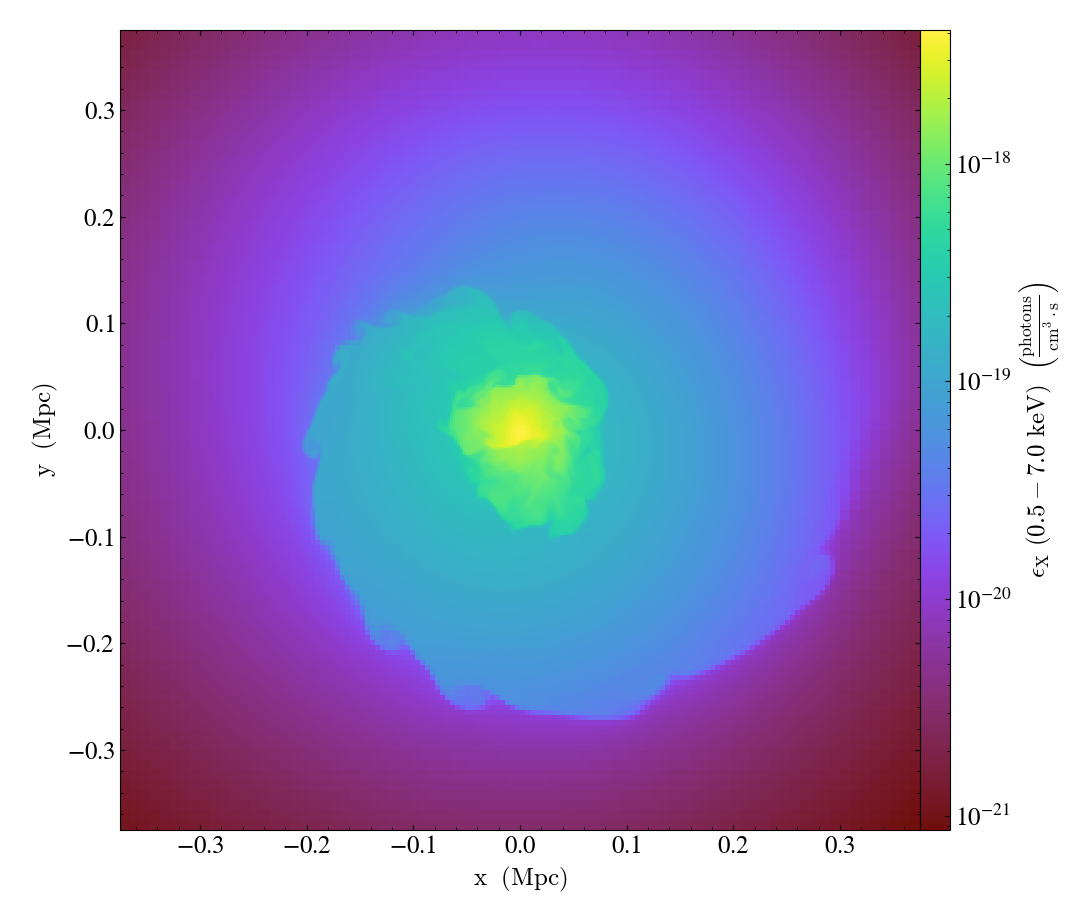

In [4]:
slc = yt.SlicePlot(
    ds,
    "z",
    [
        ("gas", "xray_emissivity_0.5_7.0_keV"),
        ("gas", "xray_photon_emissivity_0.5_7.0_keV"),
    ],
    width=(0.75, "Mpc"),
)
slc.show()

The emissivity and the luminosity fields take the values one would see in the frame of the source. However, if one wishes to make projections of the X-ray emission from a cosmologically distant object, the energy band will be redshifted. For this case, one can supply a `redshift` parameter and a `Cosmology` object (either from the dataset or one made on your own) to compute X-ray intensity fields along with the emissivity and luminosity fields.

This example shows how to do that, Where we also use a spatially dependent metallicity field and the Cloudy tables instead of the APEC tables we used previously:

In [5]:
ds2 = yt.load("D9p_500/10MpcBox_HartGal_csf_a0.500.d", default_species_fields="ionized")

# In this case, use the redshift and cosmology from the dataset,
# but in theory you could put in something different
xray_fields2 = yt.add_xray_emissivity_field(
    ds2,
    0.5,
    2.0,
    redshift=ds2.current_redshift,
    cosmology=ds2.cosmology,
    metallicity=("gas", "metallicity"),
    table_type="cloudy",
)

Now, one can see that two new fields have been added, corresponding to X-ray intensity / surface brightness when projected:

In [6]:
print(xray_fields2)

[('gas', 'xray_emissivity_0.5_2.0_keV'), ('gas', 'xray_luminosity_0.5_2.0_keV'), ('gas', 'xray_photon_emissivity_0.5_2.0_keV'), ('gas', 'xray_intensity_0.5_2.0_keV'), ('gas', 'xray_photon_intensity_0.5_2.0_keV')]


Note also that the energy range now corresponds to the *observer* frame, whereas in the source frame the energy range is between `emin*(1+redshift)` and `emax*(1+redshift)`. Let's zoom in on a galaxy and make a projection of the energy intensity field:


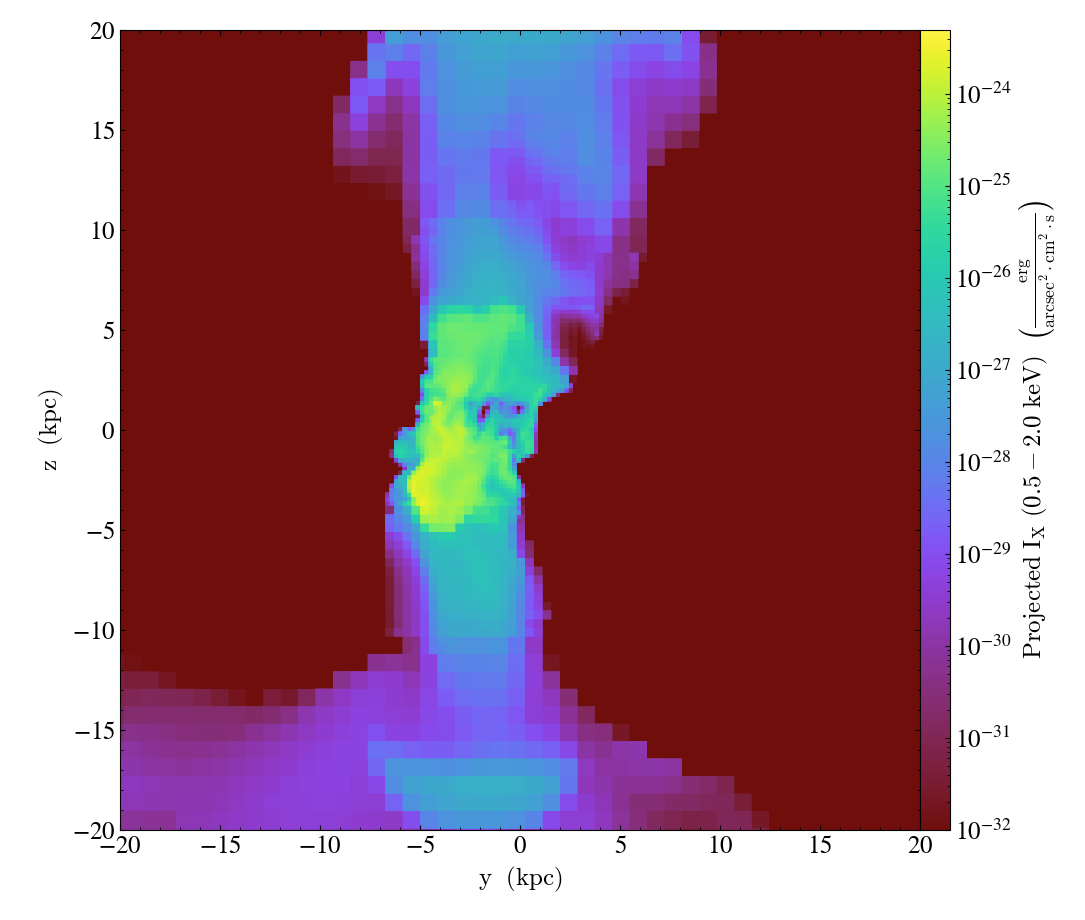

In [7]:
prj = yt.ProjectionPlot(
    ds2, "x", ("gas", "xray_intensity_0.5_2.0_keV"), center="max", width=(40, "kpc")
)
prj.set_zlim("xray_intensity_0.5_2.0_keV", 1.0e-32, 5.0e-24)
prj.show()

> Warning: The X-ray fields depend on the number density of hydrogen atoms, given by the yt field
  `H_nuclei_density`. In the case of the APEC model, this assumes that all of the hydrogen in your
  dataset is ionized, whereas in the Cloudy model the ionization level is taken into account. If 
  this field is not defined (either in the dataset or by the user), it will be constructed using
  abundance information from your dataset. Finally, if your dataset contains no abundance information,
  a primordial hydrogen mass fraction (X = 0.76) will be assumed.

Finally, if you want to place the source at a local, non-cosmological distance, you can forego the `redshift` and `cosmology` arguments and supply a `dist` argument instead, which is either a `(value, unit)` tuple or a `YTQuantity`. Note that here the redshift is assumed to be zero. 

In [8]:
xray_fields3 = yt.add_xray_emissivity_field(
    ds2,
    0.5,
    2.0,
    dist=(1.0, "Mpc"),
    metallicity=("gas", "metallicity"),
    table_type="cloudy",
)


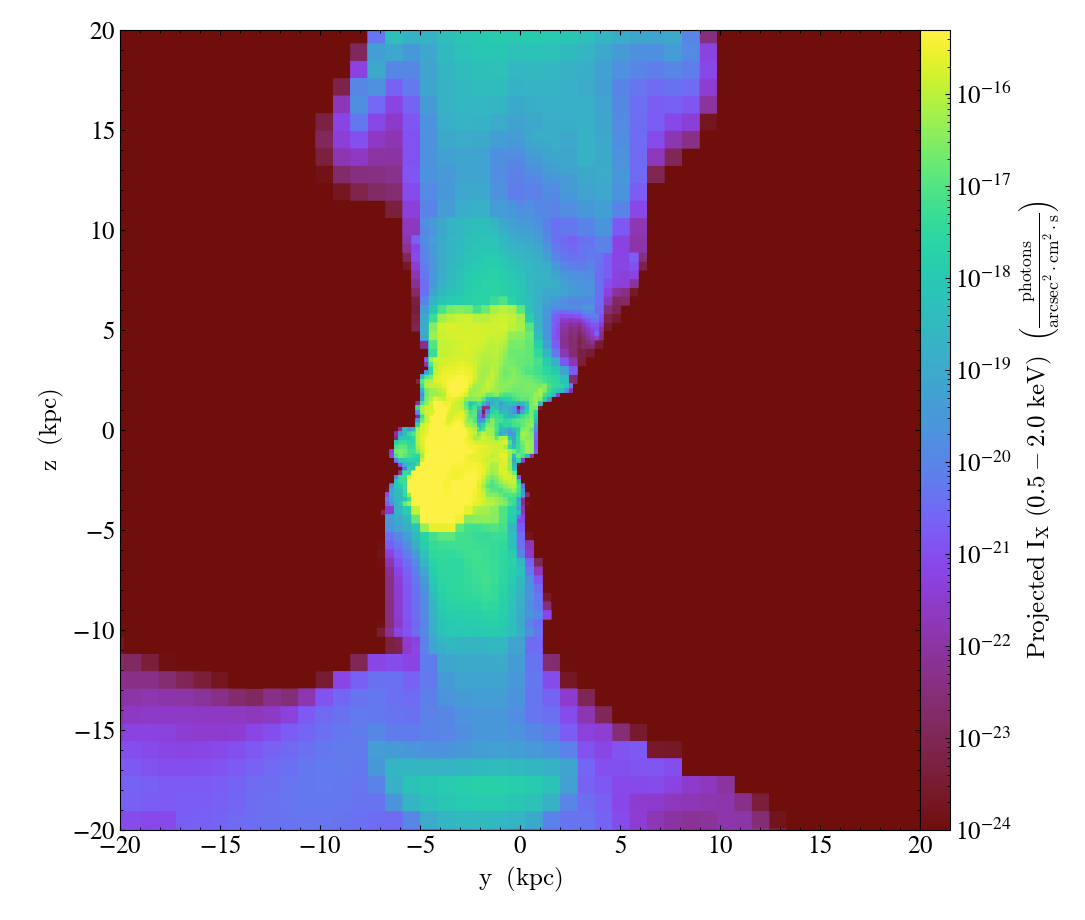

In [9]:
prj = yt.ProjectionPlot(
    ds2,
    "x",
    ("gas", "xray_photon_intensity_0.5_2.0_keV"),
    center="max",
    width=(40, "kpc"),
)
prj.set_zlim("xray_photon_intensity_0.5_2.0_keV", 1.0e-24, 5.0e-16)
prj.show()